In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
df = pd.read_csv('twcs.csv')
df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [134]:
df['created_at'] = pd.to_datetime(df['created_at'])

<ipython-input-134-eb962bb2d325>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['created_at'] = pd.to_datetime(df['created_at'])


In [135]:
inbounds = df.loc[df['inbound'] == True]
outbounds = df.loc[df['inbound'] == False]

df = pd.merge(outbounds, inbounds, left_on='in_response_to_tweet_id', right_on='tweet_id', how='outer')

In [136]:
response_time_df = df[(df['inbound_x'] == False) & (df['inbound_y'] == True)]
response_time_df['response_time'] = (response_time_df['created_at_x'] - response_time_df['created_at_y']).dt.total_seconds() /60
avg_response_time_by_company = response_time_df.groupby('author_id_x')['response_time'].mean().reset_index()
avg_response_time_by_company.columns = ['Company', 'Avg_Response_Time']

<ipython-input-136-5621bf5281f5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  response_time_df['response_time'] = (response_time_df['created_at_x'] - response_time_df['created_at_y']).dt.total_seconds() /60


In [137]:
resolution_time_df = df[(df['inbound_y'] == True) & (df['inbound_x'] == False)]
first_customer_tweet = resolution_time_df.groupby('tweet_id_y')['created_at_y'].min().reset_index()
last_support_tweet = resolution_time_df.groupby('tweet_id_y')['created_at_x'].max().reset_index()

resolution_time_df = pd.merge(first_customer_tweet, last_support_tweet, on='tweet_id_y', suffixes=('_customer', '_support'))

resolution_time_df['resolution_time'] = (resolution_time_df['created_at_x'] - resolution_time_df['created_at_y']).dt.total_seconds() /60
resolution_time_df = pd.merge(resolution_time_df, df[['tweet_id_y', 'author_id_x']], on='tweet_id_y', how='left')

avg_resolution_time_by_company = resolution_time_df.groupby('author_id_x')['resolution_time'].mean().reset_index()
avg_resolution_time_by_company.columns = ['Company', 'Avg_Resolution_Time']
avg_resolution_time_by_company

,Company,Avg_Resolution_Time
0,ATT,786.031717
1,ATVIAssist,2399.042386
2,AWSSupport,1458.585893
3,AdobeCare,504.909210
4,AirAsiaSupport,731.489550
...,...,...
103,mediatemplehelp,18.987037
104,nationalrailenq,29.675121
105,sainsburys,619.353706
106,sizehelpteam,108.009679


In [138]:
total_interactions_per_convo = df.groupby('tweet_id_y').size().reset_index(name='interactions')
total_interactions_per_convo['Company'] = df.groupby('tweet_id_y')['author_id_x'].first().values
avg_interactions_per_convo_by_company = total_interactions_per_convo.groupby('Company')['interactions'].mean().reset_index()
avg_interactions_per_convo_by_company.columns = ['Company', 'Avg_Interactions_Per_Conversation']


In [139]:
df['text_y']=df['text_y'].astype(str)
df['customer_sentiment'] = df['text_y'].apply(lambda x: TextBlob(x).sentiment.polarity)
avg_sentiment_by_company = df.groupby('author_id_x')['customer_sentiment'].mean().reset_index()
avg_sentiment_by_company.columns = ['Company', 'Avg_Sentiment']

In [140]:
company_comparison_df = avg_response_time_by_company.merge(avg_resolution_time_by_company, on='Company', how='left')
company_comparison_df = company_comparison_df.merge(avg_interactions_per_convo_by_company, on='Company', how='left')
company_comparison_df = company_comparison_df.merge(avg_sentiment_by_company, on='Company', how='left')

company_comparison_df

,Company,Avg_Response_Time,Avg_Resolution_Time,Avg_Interactions_Per_Conversation,Avg_Sentiment
0,ATT,723.137625,786.031717,1.016158,0.034931
1,ATVIAssist,2398.584702,2399.042386,1.035294,-0.029430
2,AWSSupport,1383.974032,1458.585893,1.022989,0.047739
3,AdobeCare,444.719111,504.909210,1.152006,0.035654
4,AirAsiaSupport,731.248674,731.489550,1.246667,0.047095
...,...,...,...,...,...
103,mediatemplehelp,18.938360,18.987037,1.086207,0.032925
104,nationalrailenq,29.668937,29.675121,1.038922,0.021719
105,sainsburys,600.655583,619.353706,1.046835,0.039592
106,sizehelpteam,107.358133,108.009679,1.017483,-0.004308


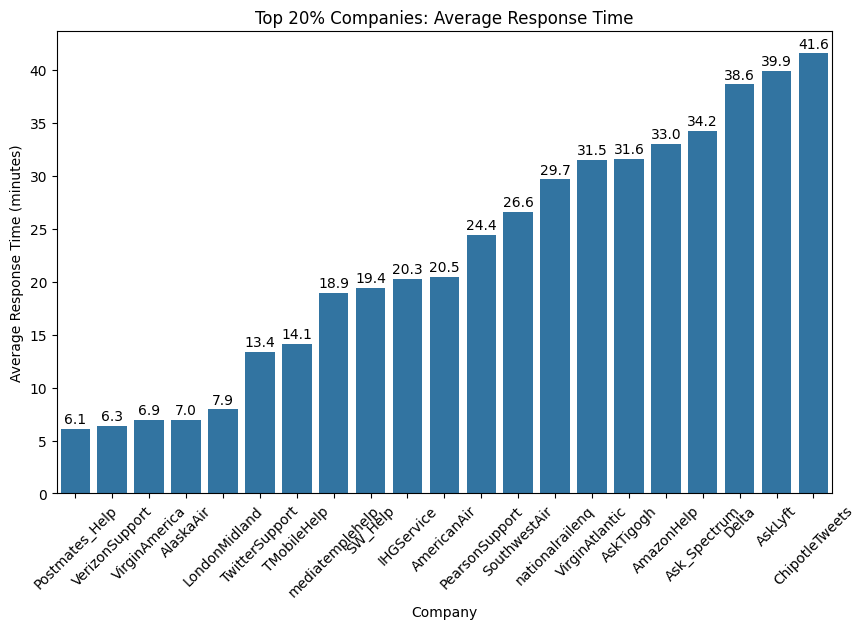

In [159]:
df_sorted_by_response_time = company_comparison_df.sort_values(by='Avg_Response_Time', ascending=True)  # Ascending order
top_25_percent_response_time = df_sorted_by_response_time.head(int(len(df_sorted_by_response_time) * 0.20))

plt.figure(figsize=(10, 6))
ax1 = sns.barplot(x='Company', y='Avg_Response_Time', data=top_25_percent_response_time)
plt.title('Top 20% Companies: Average Response Time')
plt.xticks(rotation=45)
plt.xlabel('Company')
plt.ylabel('Average Response Time (minutes)')

for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height:.1f}',
                 (p.get_x() + p.get_width() / 2., height),
                 ha='center', va='center', fontsize=10, color='black',
                 xytext=(0, 7), textcoords='offset points')

plt.show()

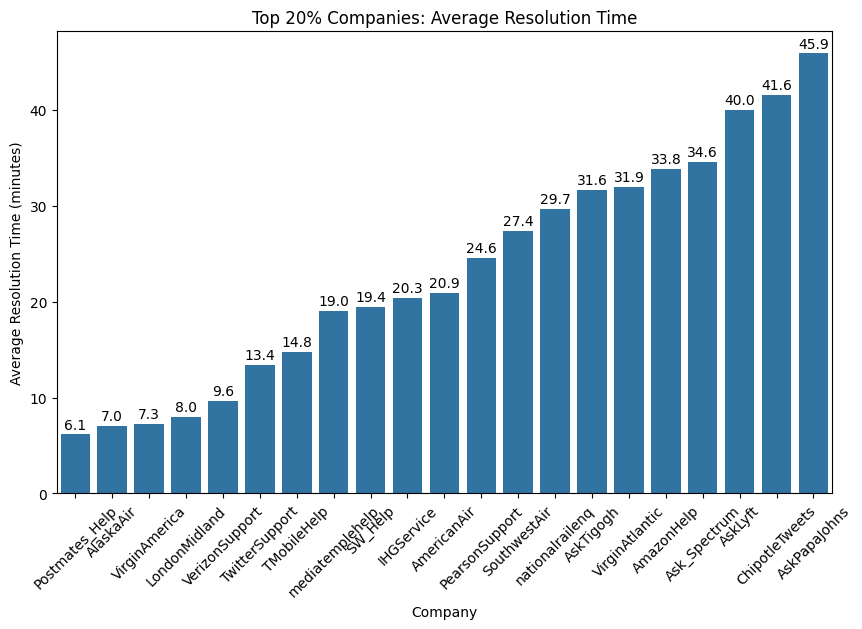

In [161]:
df_sorted_by_resolution_time = company_comparison_df.sort_values(by='Avg_Resolution_Time', ascending=True)  # Ascending order
top_25_percent_resolution_time = df_sorted_by_resolution_time.head(int(len(df_sorted_by_resolution_time) * 0.20))

plt.figure(figsize=(10, 6))
ax1 =sns.barplot(x='Company', y='Avg_Resolution_Time', data=top_25_percent_resolution_time)
plt.title('Top 20% Companies: Average Resolution Time')
plt.xticks(rotation=45)
plt.xlabel('Company')
plt.ylabel('Average Resolution Time (minutes)')
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height:.1f}',
                 (p.get_x() + p.get_width() / 2., height),
                 ha='center', va='center', fontsize=10, color='black',
                 xytext=(0, 7), textcoords='offset points')

plt.show()

In [191]:
df_sorted_by_interactions = company_comparison_df.sort_values(by='Avg_Interactions_Per_Conversation', ascending=True)
top_25_percent_interactions = df_sorted_by_interactions.head(int(len(df_sorted_by_interactions) * 0.20))
top_25_percent_interactions[['Company','Avg_Interactions_Per_Conversation']]


,Company,Avg_Interactions_Per_Conversation
53,JackBox,1.000000
43,DunkinDonuts,1.000000
96,askpanera,1.000000
47,GooglePlayMusic,1.000000
57,Kimpton,1.000000
21,AskRobinhood,1.000000
19,AskPlayStation,1.000000
82,TwitterSupport,1.000000
15,AskDSC,1.000000
10,AppleSupport,1.000664


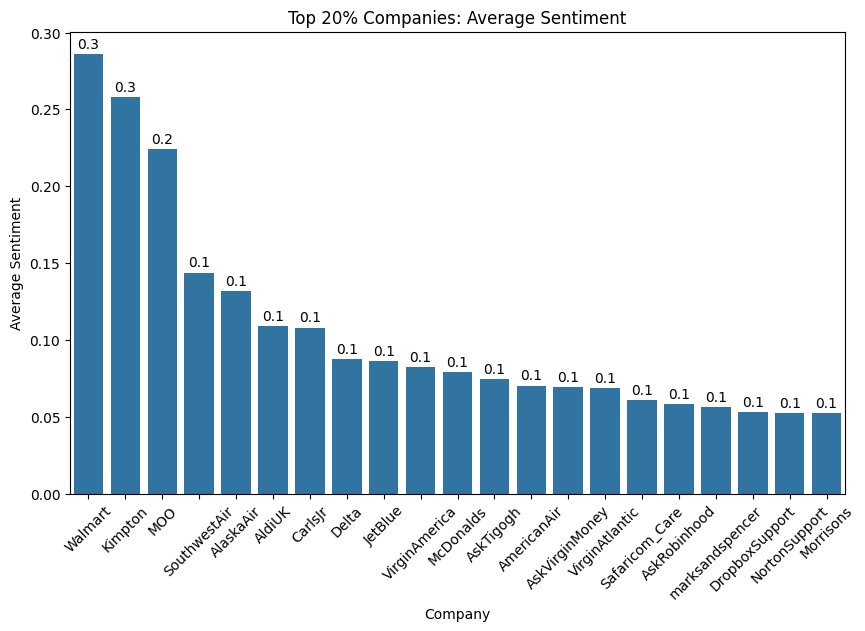

In [163]:
df_sorted_by_sentiment = company_comparison_df.sort_values(by='Avg_Sentiment', ascending=False)
top_25_percent_sentiment = df_sorted_by_sentiment.head(int(len(df_sorted_by_sentiment) * 0.20))

plt.figure(figsize=(10, 6))
ax1 = sns.barplot(x='Company', y='Avg_Sentiment', data=top_25_percent_sentiment)
plt.title('Top 20% Companies: Average Sentiment')
plt.xticks(rotation=45)
plt.xlabel('Company')
plt.ylabel('Average Sentiment')
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height:.1f}',
                 (p.get_x() + p.get_width() / 2., height),
                 ha='center', va='center', fontsize=10, color='black',
                 xytext=(0, 7), textcoords='offset points')

plt.show()

In [183]:
metrics = ['Avg_Response_Time',
           'Avg_Resolution_Time',
           'Avg_Interactions_Per_Conversation',
           'Avg_Sentiment']


metrics_summary = {}

for metric in metrics:
    avg = company_comparison_df[metric].mean()
    q1 = company_comparison_df[metric].quantile(0.25)
    q3 = company_comparison_df[metric].quantile(0.75)
    iqr = q3 - q1
    med = company_comparison_df[metric].median()


    metrics_summary[metric] = {
        'Average': avg,
        'Median': med,
        '25th percentile':q1,
        '75th percentile': q3,
        'IQR (Interquartile Range)': iqr
    }

metrics_summary_df = pd.DataFrame(metrics_summary).T

metrics_summary_df

,Average,Median,25th percentile,75th percentile,IQR (Interquartile Range)
Avg_Response_Time,578.198015,236.157590,59.211992,632.130769,572.918777
Avg_Resolution_Time,605.219544,239.581696,63.306672,672.783615,609.476943
Avg_Interactions_Per_Conversation,1.064516,1.035598,1.011467,1.093747,0.082280
Avg_Sentiment,0.023091,0.022181,-0.013596,0.042104,0.055700


In [179]:
company_comparison_df.to_csv('sqsp_data.csv', index=False)